# Pandas Performance

In this notebook we will be exploring the performance differences between different approaches of iterating through a Pandas column.  This is based on a post (that apparently no longer exists...): https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

First we will start by loading our data.  The data is from Lyft's Go Bike program and inclues every trip from 2017: https://www.lyft.com/bikes/bay-wheels/system-data

In [1]:
import pandas as pd

#change this to local path if not running on ROSIE
df = pd.read_csv('2017-fordgobike-tripdata.csv',
                 dtype={"start_station_latitude":float, "start_station_longitude":float,
                       "end_station_latitude":float, "end_station_longitude":float})
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber


Next we define a function to calculate distance based on two GPS locations

In [2]:
import numpy as np

# Define a basic Haversine distance formula
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

The slowest approach is to loop through the dataframe using `iloc`

In [3]:
def haversine_looping(df):
    distance_list = []
    for i in range(0, len(df)):
        d = haversine(df['start_station_latitude'].iloc[i], df['start_station_longitude'].iloc[i], 
                      df['end_station_latitude'].iloc[i], df['end_station_longitude'].iloc[i])
        distance_list.append(d)
    return distance_list
%time df['distance'] = haversine_looping(df)

CPU times: total: 31.7 s
Wall time: 32.8 s


In [4]:
#how many rows
print(df.shape)
df.head()

(519700, 14)


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,distance
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,0.585946
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1.907558
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,0.000000
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,0.650381
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,0.395427


Next, lets try using `iterrows()`

In [5]:
%%time
haversine_series = []
for index, row in df.iterrows():
    haversine_series.append(haversine(row['start_station_latitude'], row['start_station_longitude'], 
                                      row['end_station_latitude'], row['end_station_longitude']))
df['distance'] = haversine_series

CPU times: total: 40.2 s
Wall time: 42.1 s


Next, lets use some functional programming!  Try using `apply`

In [6]:
%time df['distance'] = df.apply(lambda row: haversine(row['start_station_latitude'], \
                                                      row['start_station_longitude'], \
                                                      row['end_station_latitude'], \
                                                      row['end_station_longitude']), axis=1)

CPU times: total: 17.8 s
Wall time: 18.8 s


Lets vectorize!

In [9]:
%time df['distance'] = haversine(df['start_station_latitude'], df['start_station_longitude'], \
                                 df['end_station_latitude'], df['end_station_longitude'])

CPU times: total: 78.1 ms
Wall time: 83 ms


Lets try numpy vectorize

In [10]:
%time df['distance'] = haversine(df['start_station_latitude'], df['start_station_longitude'], \
                                 df['end_station_latitude'].values, df['end_station_longitude'].values)

CPU times: total: 109 ms
Wall time: 79.3 ms


Use matplotlib to make a bar chart summarizing the performance data. Feel free to hard-code in the runtime values found above.

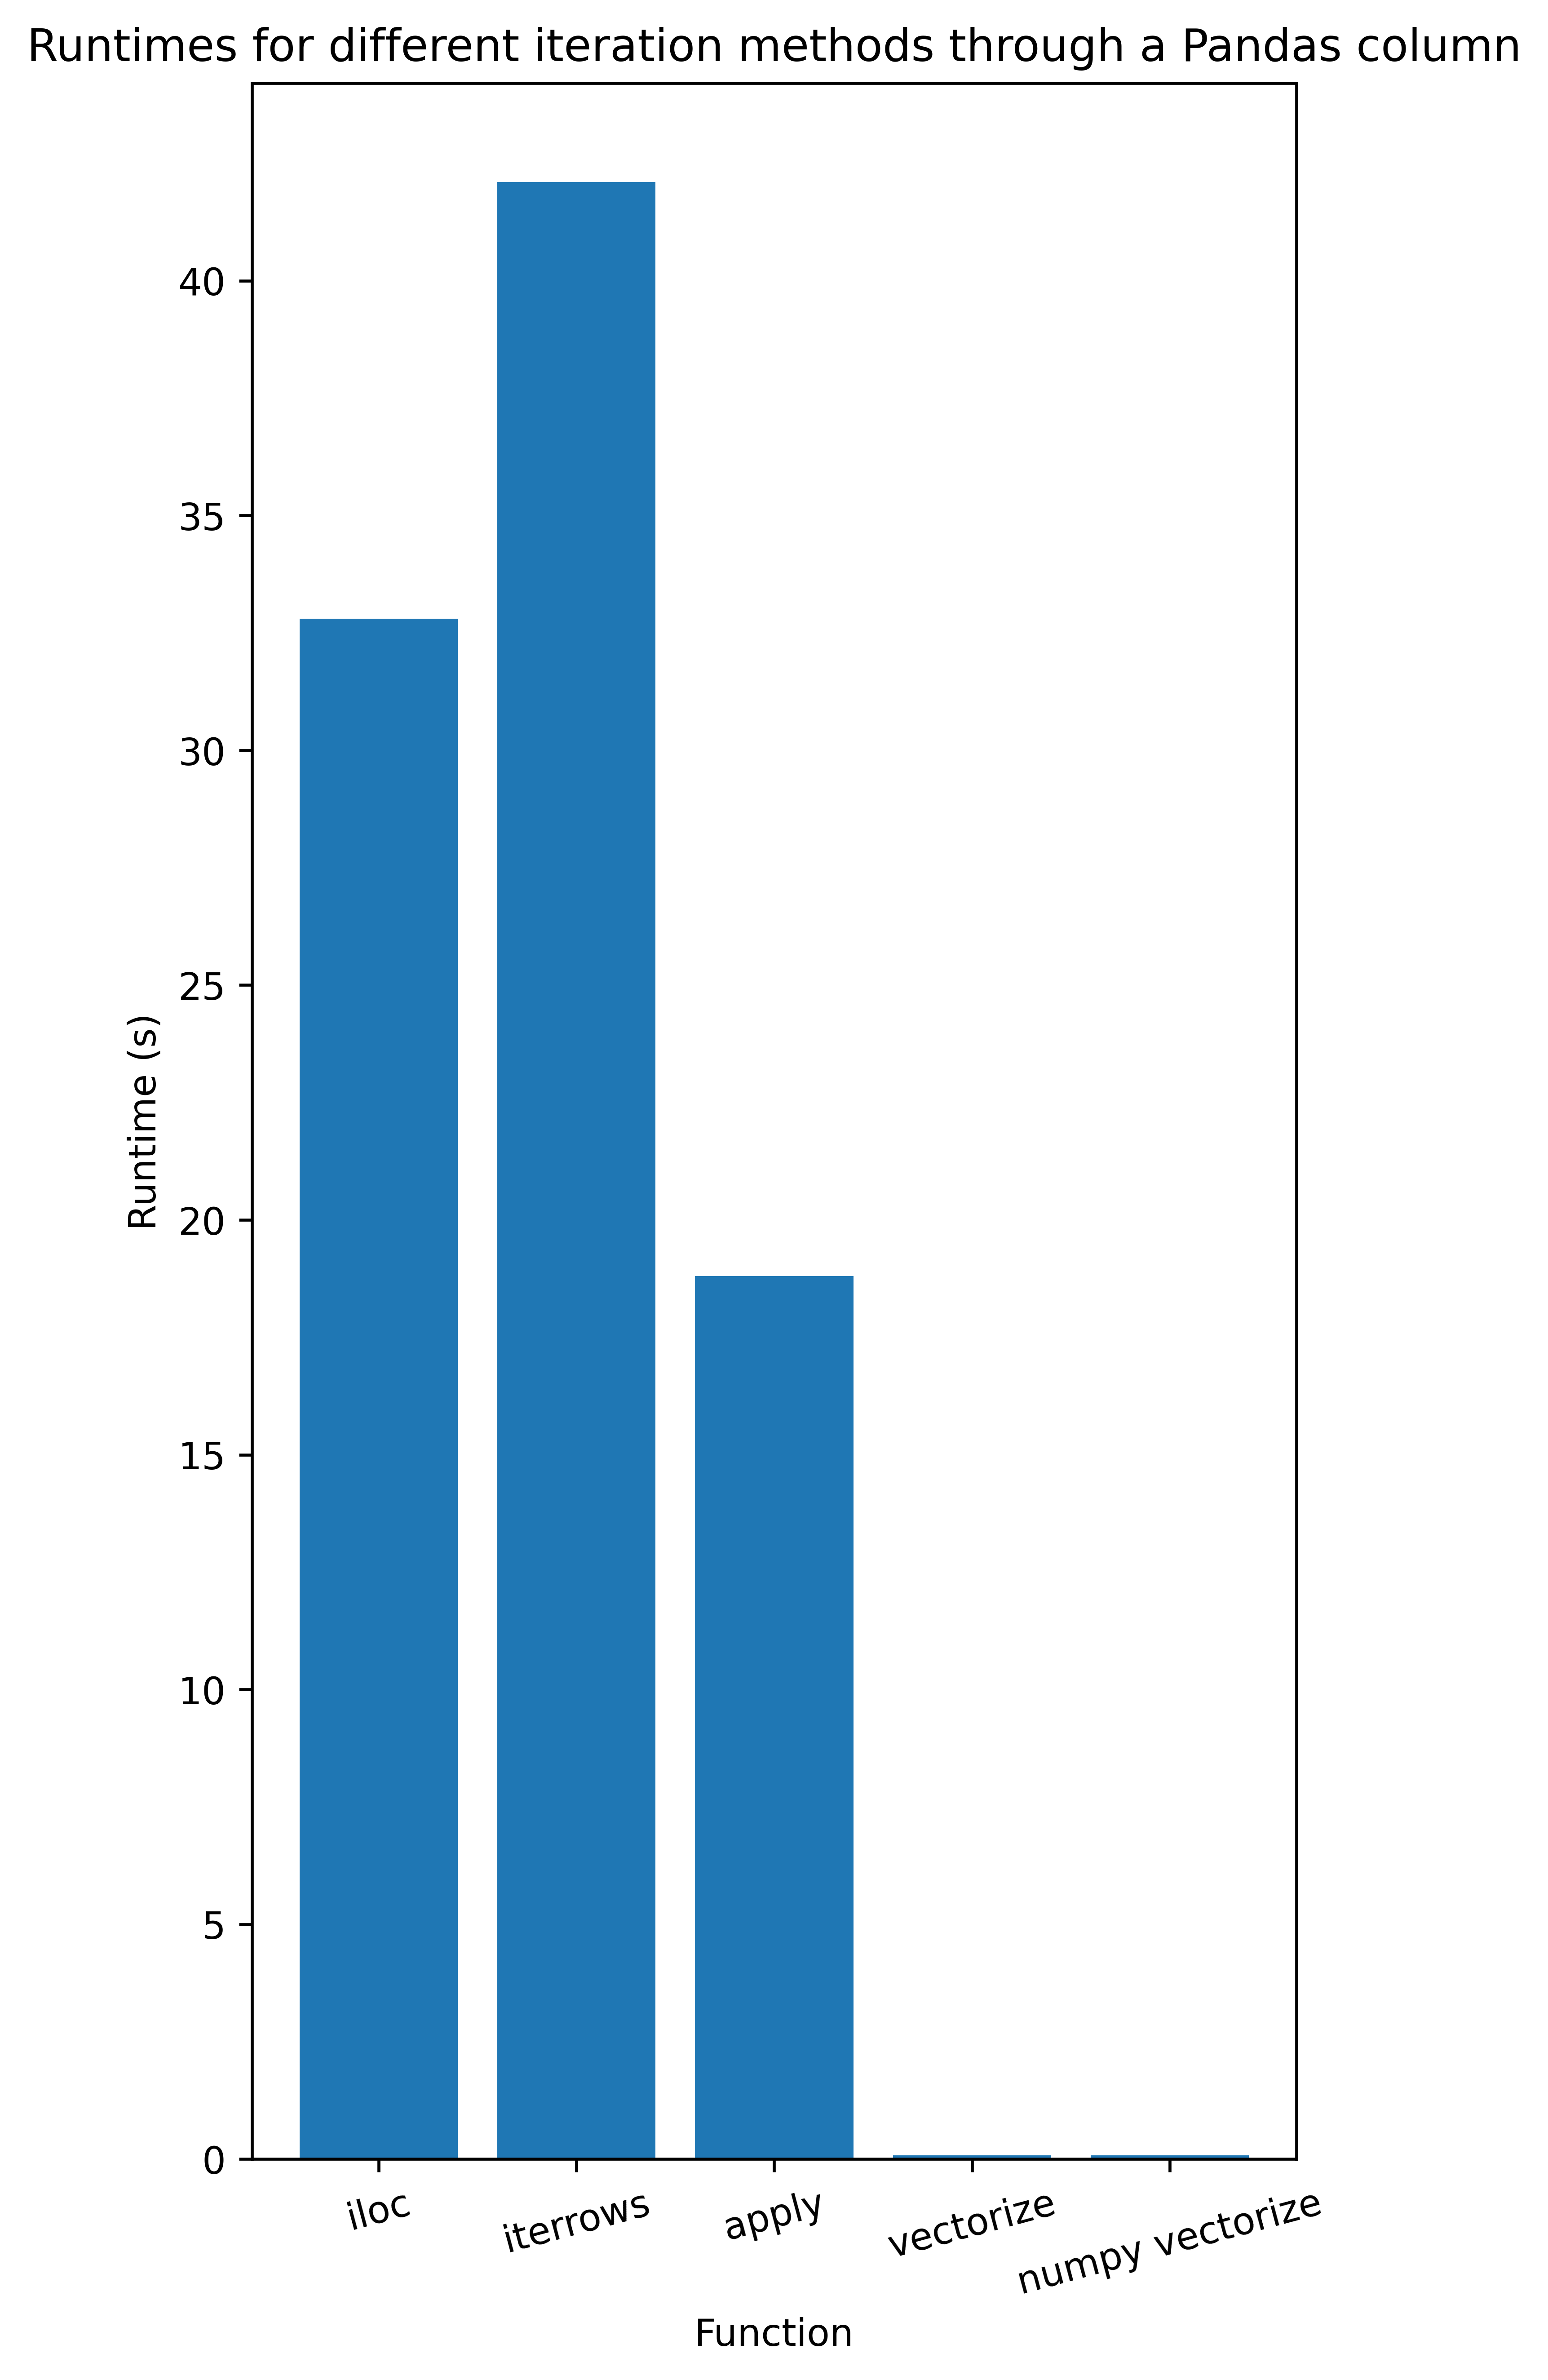

In [24]:
import matplotlib.pyplot as plt

functions = ["iloc", "iterrows", "apply", "vectorize", "numpy vectorize"]
times = [32.8, 42.1, 18.8, 0.083, 0.0793]

plt.figure(figsize=[5,10], dpi=600)
plt.bar(functions, times)
plt.xlabel("Function")
plt.xticks(rotation=15)
plt.ylabel("Runtime (s)")
plt.title("Runtimes for different iteration methods through a Pandas column")
plt.show()